In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

#%tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD


In [37]:
aapl_df = pd.read_csv("AAPL.csv")
fb_df = pd.read_csv("FB.csv")
amzn_df = pd.read_csv("AMZN.csv")
goog_df = pd.read_csv("GOOG.csv")
nflx_df = pd.read_csv("NFLX.csv")

In [38]:
print(aapl_df.shape)
print(aapl_df.columns)
aapl_df.isnull().values.any()
aapl_df = aapl_df.dropna()
aapl_df.shape

(9909, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


(9909, 7)

In [39]:
print(fb_df.shape)
print(fb_df.columns)
fb_df.isnull().values.any()
fb_df = fb_df.dropna()
fb_df.shape

(1980, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


(1980, 7)

In [40]:
print(amzn_df.shape)
print(amzn_df.columns)
amzn_df.isnull().values.any()
amzn_df = amzn_df.dropna()
amzn_df.shape

(5758, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


(5758, 7)

In [41]:
print(nflx_df.shape)
print(nflx_df.columns)
nflx_df.isnull().values.any()
nflx_df = nflx_df.dropna()
nflx_df.shape

(4496, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


(4496, 7)

In [42]:
print(goog_df.shape)
print(goog_df.columns)
goog_df.isnull().values.any()
goog_df = goog_df.dropna()
goog_df.shape

(3932, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


(3932, 7)

In [43]:
fb_df.index = pd.to_datetime(fb_df['Date'])
aapl_df.index = pd.to_datetime(aapl_df['Date'])
amzn_df.index = pd.to_datetime(amzn_df['Date'])
nflx_df.index = pd.to_datetime(nflx_df['Date'])
goog_df.index = pd.to_datetime(goog_df['Date'])

Text(0.5, 1.0, 'GOOG Open/Close Prices')

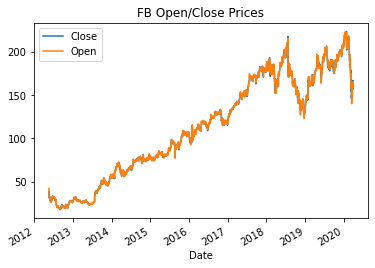

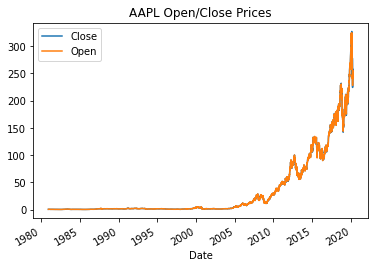

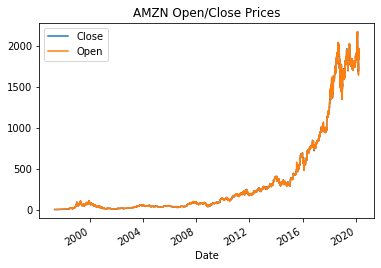

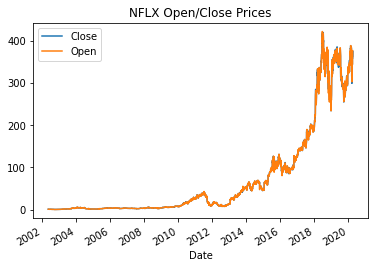

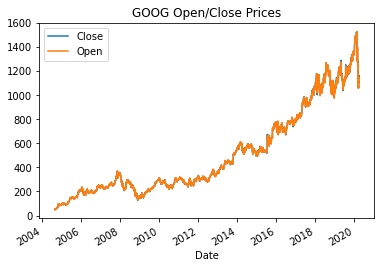

In [44]:
fb_df[['Close', 'Open']].plot()
#fb_df.iloc[0:1000].plot(y = 'Close')
plt.title('FB Open/Close Prices')

aapl_df[['Close', 'Open']].plot()
plt.title('AAPL Open/Close Prices')

amzn_df[['Close', 'Open']].plot()
plt.title('AMZN Open/Close Prices')

nflx_df[['Close', 'Open']].plot()
plt.title('NFLX Open/Close Prices')

goog_df[['Close', 'Open']].plot()
plt.title('GOOG Open/Close Prices')

In [45]:
def smape_kun(y_true, y_pred):
    # START_CODE_HERE
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    # END_CODE_HERE

In [46]:
def model_LSTM(df):
    # Splitting the train and test set considering 'Open' feature from the dataset
    train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]
    train_series = train_data['Open']
    test_series = test_data['Open']
    train_series.shape, test_series.shape
    
    train_series.plot(kind='line', label='train')
    test_series.plot(kind='line', label='test')
    
    sc = MinMaxScaler(feature_range=(0,1))
    # START_CODE_HERE
    training_set_scaled = sc.fit_transform(train_series.values.reshape(-1, 1))
    # END_CODE_HERE
    
    X_train = []
    y_train = []
    for i in range(60, len(training_set_scaled)):
        X_train.append(training_set_scaled[i-60:i,0])
        y_train.append(training_set_scaled[i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
    
    regressor = Sequential()

    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
    regressor.add(Dropout(0.2))

    # Second LSTM layer
    regressor.add(LSTM(units=64))

    # The output layer
    regressor.add(Dense(1, activation='relu'))

    # Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
    regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

    print(regressor.summary())
    
    regressor.fit(X_train,y_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=False)
    train_last60 = train_series.tail(60)
    assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")
    
    new_test_series =  pd.concat([train_last60, test_series], axis=0)
    test_set_scaled = sc.fit_transform(new_test_series.values.reshape(-1, 1))
    
    X_test = []
    for i in range(60,len(test_set_scaled)):
        X_test.append(test_set_scaled[i-60:i,0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price_revtrans = sc.inverse_transform(predicted_stock_price).ravel()
    predicted_stock_price_revtrans_series = pd.Series(predicted_stock_price_revtrans)
    predicted_stock_price_revtrans_series.index = test_series.index
    
    error = mean_squared_error(test_series, predicted_stock_price_revtrans_series)
    print('Testing Mean Squared Error: %.3f' % error)
    error2 = smape_kun(test_series, predicted_stock_price_revtrans_series)
    print('Symmetric Mean absolute percentage error: %.3f' % error2)
    
    plt.figure(figsize=(12,7))
    plt.title('Prices')
    plt.xlabel('Dates')
    plt.ylabel('Prices')
    plt.plot(train_series, color='blue', label='Training Prices')
    plt.plot(test_series, color='green', label='Testing Prices')
    plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
    plt.legend();
    
    plt.figure(figsize=(12,7))
    plt.title('Prices')
    plt.xlabel('Dates')
    plt.ylabel('Prices')
    plt.plot(test_series, color='green', label='Testing Prices')
    plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
    plt.legend();

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 60, 64)            16896     
                                                                 
 dropout_15 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_31 (LSTM)              (None, 64)                33024     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
111/111 [==============================] - 18s 110ms/step - loss: 2.7082e-04 - val_loss: 0.0353
Epoch 2/15
111/111 [==============================] - 11s 98ms/step -

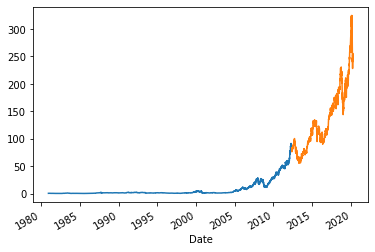

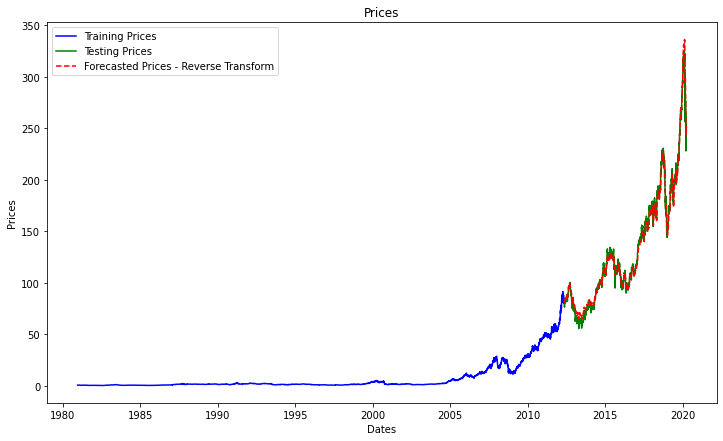

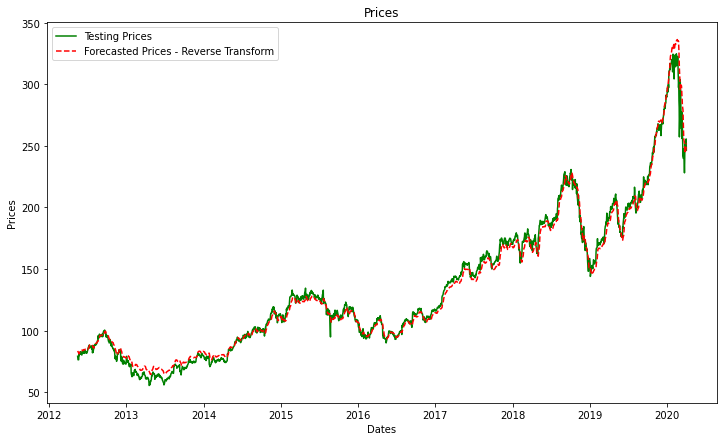

In [53]:
model_LSTM(aapl_df)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 60, 64)            16896     
                                                                 
 dropout_10 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_21 (LSTM)              (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
22/22 [==============================] - 9s 136ms/step - loss: 0.0073 - val_loss: 0.0103
Epoch 2/15
22/22 [==============================] - 2s 92ms/step - loss: 0.0

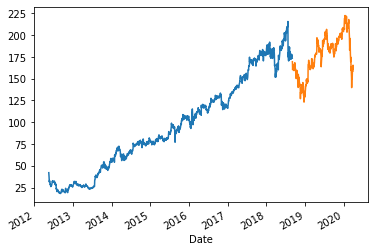

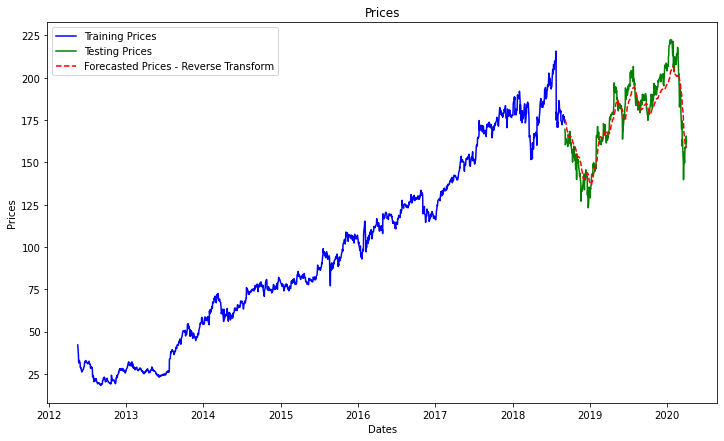

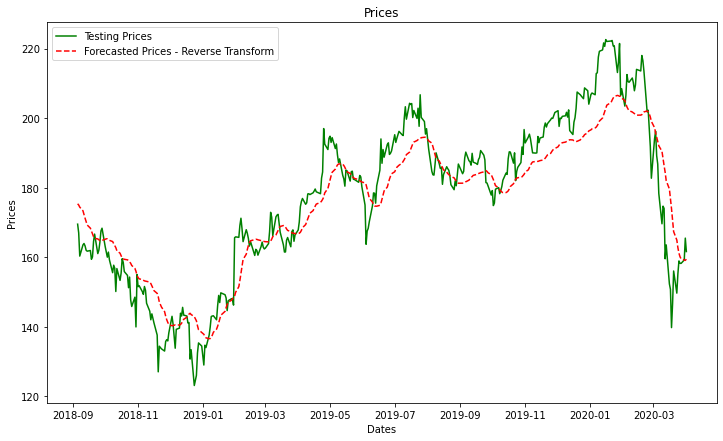

In [48]:
model_LSTM(fb_df)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 60, 64)            16896     
                                                                 
 dropout_11 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_23 (LSTM)              (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
64/64 [==============================] - 13s 122ms/step - loss: 0.0012 - val_loss: 0.0066
Epoch 2/15
64/64 [==============================] - 6s 95ms/step - loss: 0.

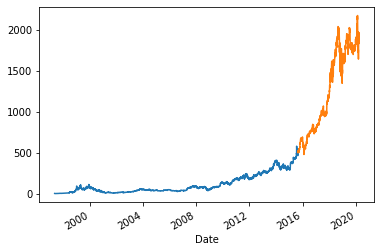

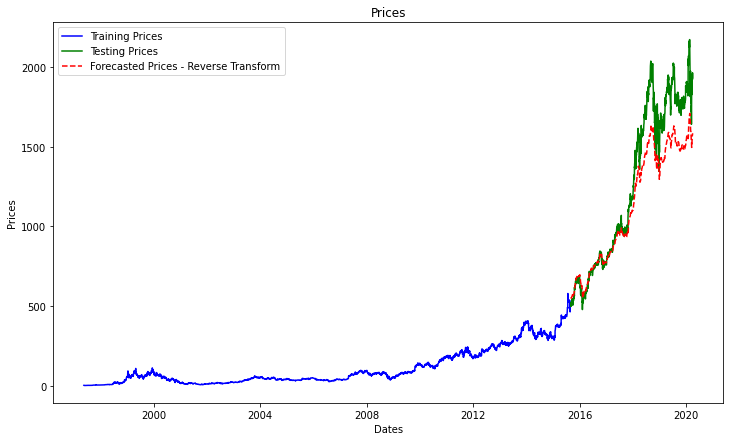

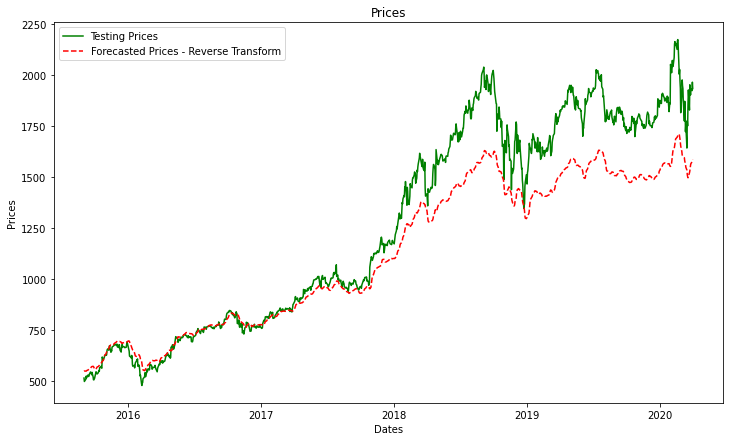

In [49]:
model_LSTM(amzn_df)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 60, 64)            16896     
                                                                 
 dropout_12 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_25 (LSTM)              (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
50/50 [==============================] - 13s 124ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 2/15
50/50 [==============================] - 5s 94ms/step - loss: 0.

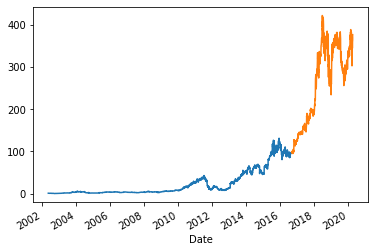

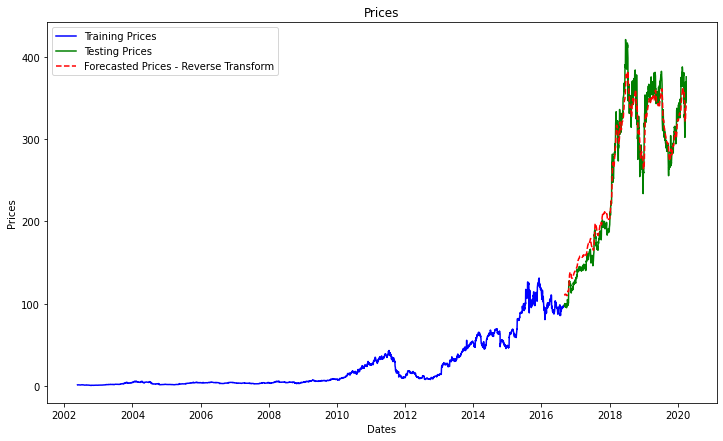

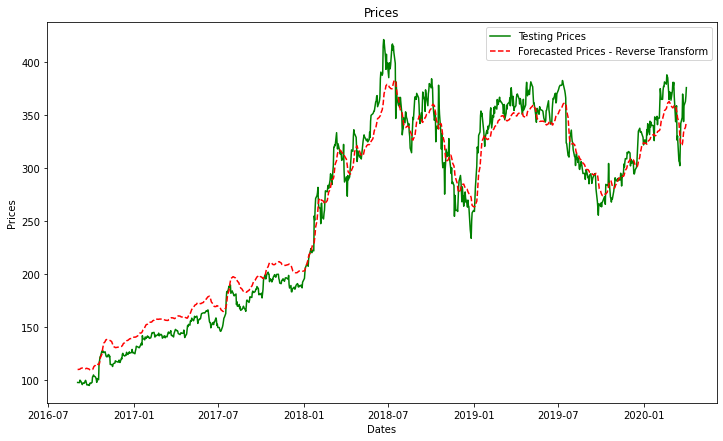

In [50]:
model_LSTM(nflx_df)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 60, 64)            16896     
                                                                 
 dropout_13 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_27 (LSTM)              (None, 64)                33024     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
44/44 [==============================] - 11s 134ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 2/15
44/44 [==============================] - 4s 97ms/step - loss: 0.

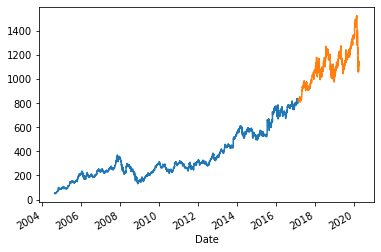

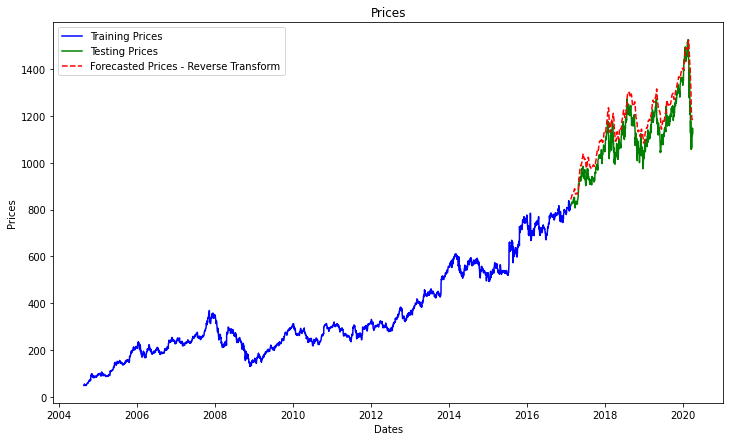

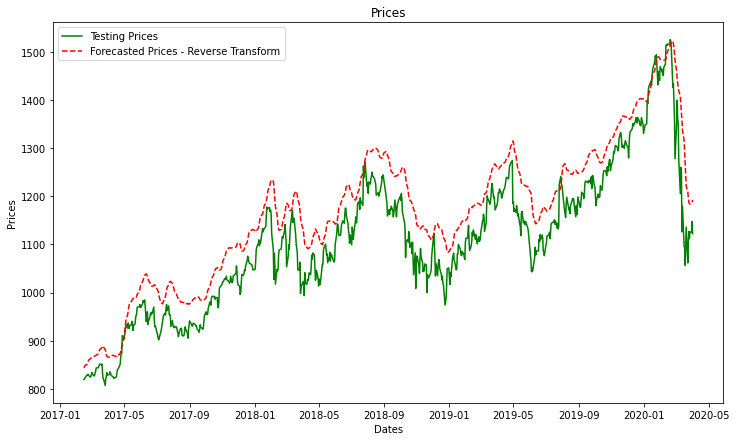

In [51]:
model_LSTM(goog_df)